# Bibliotecas


In [1]:
import warnings
warnings.filterwarnings("ignore")  # Ignorar todos os avisos

# Bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import style
import scikitplot

# Bibliotecas de Pré-processamentos dos dados
from sklearn.preprocessing import StandardScaler

# Treinamento do banco de dados
from sklearn.model_selection import LeaveOneOut, GridSearchCV

# Modelos utilizados
from sklearn.neighbors import KNeighborsClassifier   #k-vizinhos mais próximos
from sklearn.tree import DecisionTreeClassifier      # árvore de decisão
from sklearn.ensemble import RandomForestClassifier  # RandomForest
from sklearn.svm import SVC                          # Support Vector Machines
import xgboost as xgb                                # XGBoosting
from catboost import CatBoostClassifier              # CatBoost
from sklearn.linear_model import LogisticRegression  # Regressão Logística

# Validação do modelo
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, make_scorer

# Calibração das probabilidades do modelo
from sklearn.calibration import CalibratedClassifierCV

# Biblioteca para balanceamento dos dados
from imblearn.over_sampling import SMOTE

# Análise de importância das variáveis
import shap

from sklearn.utils import check_random_state

np.random.seed(42)
SEED = check_random_state(42)

In [2]:
# Layout dos gráficos
sns.set_theme()
style.use('fivethirtyeight')
sns.set(font_scale = 1.2)

# Definir as cores que serão usadas nos gráficos
cores = ['deepskyblue', 'darkgreen']

# Funções

In [3]:
def my_scatterplot(df:pd.DataFrame, xlabel: str, ylabel:str):
    """Função para visualizar o gráfico de dispersão de dois atributos, identificados pela classe

    Parâmetros:
    --------------

    df -----> Dados do problema no formato de DataFrame da biblioteca Pandas
    xlabel -> Uma string com o nome da coluna que deseja visualizar para o eixo X
    ylabel -> Uma string com o nome da coluna que deseja visualizar para o eixo Y
    """
    plt.figure(figsize=(6,6))
    sns.scatterplot(data = df, x = xlabel, y = ylabel, hue= "Class")
    att1 = df[xlabel].name
    att2 = df[ylabel].name

    plt.tight_layout()
    plt.savefig(f'{xlabel}_{ylabel}.png')
    plt.title(f"Distribuição do atributo: {att1} com atributo: {att2}", fontsize = 16)

In [4]:
def my_info_graphic(df:pd.DataFrame, col:str):
    """Função para visualizar o Histograma e Boxplot do atributo

    Parâmetros:
    ------------

    df --> Dados do problema no formato de DataFrame da biblioteca Pandas
    col -> Uma string com o nome da coluna que deseja visualizar os gráficos
    """

    fig = plt.figure(figsize=(8,5))

    atributo = df[col]

    # Criar a grade em que os gráficos serão plotados
    grade = GridSpec(nrows= 2, ncols= 1)

    # Escolher uma das cores para o gráfico
    cor = np.random.choice(cores, 1)[0]

    # Assimetria do atributo em questão
    print(f"Assimetria de {atributo.name}: {atributo.skew()}")
    print(f"Curtose de {atributo.name}: {atributo.kurtosis()}")

    # Histograma do atributo
    ax_zero = fig.add_subplot(grade[0,:])
    ax_zero.set_title(f"Histograma e Boxplot de {atributo.name}", y = 1.05)
    sns.histplot(data=atributo, ax = ax_zero, color = cor)

    # Boxplot do atributo
    ax_one = fig.add_subplot(grade[1,:])
    plt.axis("off")
    sns.boxplot(x=atributo, ax = ax_one, color= cor)
    plt.tight_layout()

    plt.savefig(f'hist_{atributo.name}.png')
    plt.show()



In [5]:
def plot_qualitative_att(df_input:pd.DataFrame, col_att:str, label_att1:str, label_att2:str):
    '''
    Função para visualizar variável qualitativa nominal com relação ao atributo valor do problema

    Parâmetros:
    ------------

    df - pandas Dataframe contendo todos os dados
    col_att - é a string da coluna (atributo) que se deseja visualizar
    label_att1 - uma string de um valor da variável qualitativa
    label_att2 - uma string de um valor da variável qualitativa

    Exemplo:
    label_att1 = 'Feminino'
    label_att2 = 'Masculino'
    '''
    # # Contagem de instâncias para cada combinação de valor do atributo binário e classe

    att1 = df_input[df_input[col_att] == 0].Class.value_counts()
    att2 = df_input[df_input[col_att] == 1].Class.value_counts()

    data = {label_att2: att2.values,
           label_att1 : att1.values}
    df = pd.DataFrame(data)

    # Plot do gráfico de barras
    x = [0, 1]
    width = 0.35

    fig, ax = plt.subplots()
    ax.bar(x, df[label_att2], width, label=label_att2, color = cores[1])
    ax.bar([i + width for i in x], df[label_att1], width, label=label_att1, color = cores[0])

    # Adicionar rótulos nas barras
    for i, j in enumerate(x):
        ax.text(j, df[label_att2][i], str(df[label_att2][i]), ha='center', va='bottom')
        ax.text(j + width, df[label_att1][i], str(df[label_att1][i]), ha='center', va='bottom')

    # Configurações adicionais
    plt.xlabel('Classe')
    plt.ylabel('Quantidade')
    plt.title(f'Distribuição de pacientes que alcançaram endpoint em relação a {col_att}')
    plt.xticks([i + width/2 for i in x], ['0', '1'])
    plt.legend()
    plt.show()


In [6]:
def my_metrics(TP:int, TN:int, FP:int, FN:int):
    """
    Função auxiliar para implementação das métricas de desempenho sem utilizar bibliotecas prontas para um modelo de
    classificação.

    Parâmetros:
    ----------------

    - TP: os valores verdadeiros positivos classificados pelo modelo
    - TN: os valores verdadeiros negativos classificados pelo modelo
    - FP: os valores falsos positivos classificados pelo modelo
    - FN: os valores falsos negativos classificados pelo modelo

    Retorno:
    ----------------

    dicionário. As chaves desse dicionário serão os nomes das medidas de desempenho;
    os valores para cada chave serão as medidas de desempenho calculadas

    """

    label_complete = (TP+TN+FP+FN)

    total_error = (FN + FP) / (label_complete)
    total_accuracy = (TP + TN) / (label_complete)
    specificity = TN / (TN + FP)
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    f1_score = (2 * recall * precision) / (recall + precision)

    print('-'*40)
    print('Métricas de avaliação')
    print('-'*40)
    print(f'Taxa de acerto total = {total_accuracy*100:.4f} % \nTaxa de erro total = {total_error*100:.4f} %')
    print(f'Precisão = {precision*100:.4f} %')
    print(f'Revocação = {recall*100:.4f} %')
    print(f'Especificidade = {specificity*100:.4f} %')
    print(f'F1-score = {f1_score*100:.4f} %')

    return {"acuracia": total_accuracy,
            "sensibilidade": recall,
            "especificidade": specificity}


In [7]:
def TuningGridSearch(model, X:np.array, y:np.array, parameters: dict, cv_tuning = 10):
    """
    Função para otimizar a escolha dos hiperparâmetros do modelo.

    Parâmetros:
    ----------------

    - model: modelo de classificação a ser utilizado
    - X: base de treinamento com os atributos
    - y: base de treinando com a classe
    - parameters: um dicionário que contém os parâmetros a serem testados pelos algoritmos

    """

    scorer = make_scorer(accuracy_score)

    #cv = StratifiedKFold(n_splits=5, random_state=SEED)
    grid = GridSearchCV(estimator=model,
                        param_grid=parameters,
                        cv = cv_tuning,
                        scoring= scorer)

    grid.fit(X, y)
    #print(f'Os melhores parâmetros para o modelo são: {grid.best_params_}')
    #print(f'O melhor estimador: {grid.best_estimator_}')
    return grid.best_estimator_


In [8]:
def RunModel(model, X_model:pd.DataFrame, y:np.array, parameters = None, confusion_matrix = False, roc_curve = False, title = "")-> dict:
    """
    Função auxiliar para execução dos modelos de classificação.

    Parâmetros:
    ----------------

    model: modelo de classificação a ser utilizado
    X: base de treinamento contendo os atributos preditores
    y: base de treinamento contendo a classe
    confusion_matrix (default: False): exibir a matriz de confusão da classificação
    roc_curve (default: False): define se será exibida a curva ROC para o classificador
    title: define o título a ser exibido nos gráficos
    """
    predicts = []
    predicts_proba = []
    bests_models = []

    # Normalizando os dados
    scaler = StandardScaler()

    # Técnica de amostragem
    leave_one_out = LeaveOneOut()
    name = title
    x_loo = X_model.values
    clf = model

    for train_index, test_index in leave_one_out.split(x_loo):
        X_train_fold, X_test_fold = x_loo[train_index], x_loo[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]

        scaler.fit(X_train_fold)
        X_normalized = pd.DataFrame(scaler.transform(X_train_fold), columns= new_df.columns[1:])

        # Balanceamentos dos dados utilizando a técnica de oversampling: SMOTE
        smote = SMOTE(random_state=SEED)
        X_train_fold_resampled, y_train_fold_resampled = smote.fit_resample(X_normalized, y_train_fold)

        # Otimização de parâmetros com Busca em Grade
        best_model = TuningGridSearch(clf, X_train_fold_resampled, y_train_fold_resampled, parameters)
        bests_models.append(best_model)

        # Calibrando as probabilidades
        calibrated_classifier = CalibratedClassifierCV(best_model, cv = 'prefit')

        # Treinando o modelo com os dados de treino
        calibrated_classifier.fit(X_train_fold_resampled, y_train_fold_resampled)

        X_test_normalized = pd.DataFrame(scaler.transform(X_test_fold), columns= new_df.columns[1:])

        # Probailidades calibradas para o conjunto de teste
        calibrated_probabilities = calibrated_classifier.predict_proba(X_test_normalized)

        # Predição nos dados de teste
        y_pred = calibrated_classifier.predict(X_test_normalized)

        predicts.append(y_pred)
        predicts_proba.append(calibrated_probabilities[0])

    # Métricas de avaliação
    print(name)
    # Métricas
    true_negative, false_positive, false_negative, true_positive= metrics.confusion_matrix(y, predicts).ravel()
    results = my_metrics(TP = true_positive,
                         TN = true_negative,
                         FP = false_positive,
                         FN = false_negative)
    print('-'*40)


    # Plot matriz de confusão
    if confusion_matrix:
        scikitplot.metrics.plot_confusion_matrix(y,predicts, title = name, figsize=(4,4))
        plt.show()

    #Plot curva ROC
    if roc_curve:
        scikitplot.metrics.plot_roc(y, predicts_proba, plot_micro=False, plot_macro=False,classes_to_plot=[1],title=name,figsize=(4,4), text_fontsize= 10)

    results.update({"valores_preditos": predicts,
                    "probabilidades": predicts_proba,
                    "auc_score": metrics.roc_auc_score(y, [x[1] for x in predicts_proba]),
                    "modelo": name,
                    "best_model_for_each_fold":bests_models})

    return results


In [9]:
def CompareResults(data:list,  bar_plot=False):
    '''
    Função para comparar o resultado dos modelos desenvolvidos

    Parâmetros:
    ----------------

    data: lista
        é uma matriz que contém o nome de cada modelo, acurácia, especificidade e sensibilidade

    bar_plot (default False)
        um parâmetro opcional para visualizar graficamente a comparação entre os modelos

    auc_curve (default False)
        um parâmetro opcional para visualizar as áreas abaixo da curva (AUC) entre os modelos

    '''

    col_names = ["Model", "Accuracy", "Specificity", "Recall", "AUC"]

    df_results = pd.DataFrame(data, columns = col_names) # transformando os resultados do teste em um data.frame

    # função para destacarmos os maiores valores em cada uma das métricas
    def highlight_max(s):
        if s.dtype == object:
            is_max = [False for _ in range(s.shape[0])] # quando o tipo de dado for objeto, não aplicaremos o highlight
        else:
            is_max = s == s.max()
        return ['background: blue' if cell else '' for cell in is_max]

    print('Tabela - Comparação geral das métricas de avaliação para os modelos')
    display(df_results.style.apply(highlight_max))

    if bar_plot:
        fig, axs = plt.subplot_mosaic([['a)', 'b)'], ['c)', 'b)']], layout = 'constrained', figsize = (14,8))

        for label, ax in axs.items():
            sns.barplot(data=df_results, x = 'Model', y = 'Accuracy', ax = axs['a)'])
            sns.barplot(data=df_results, x = 'Model', y = 'Specificity', ax = axs['b)'])
            sns.barplot(data=df_results, x = 'Model', y = 'Recall', ax = axs['c)'])

            ax.text(0.0, 1.0, label, transform=ax.transAxes ,
                    fontsize='medium', va='bottom', fontfamily='serif')

        plt.suptitle('Comparação entre modelos')
        plt.tight_layout()
        plt.show()


# 1. Introdução

A periodontite é uma doença inflamatória  que afeta os tecidos de suporte dos dentes. É causada pela acumulação de placa bacteriana nos dentes e na linha da gengiva, resultando em gengivas inflamadas, sangramento, mau hálito e possível perda dentária se não for tratada. O tratamento envolve a remoção da placa bacteriana e tártaro, bem como cuidados de higiene bucal adequados. A diabetes tipo 2 é uma condição crônica caracterizada por altos níveis de açúcar no sangue devido à resistência à insulina ou à produção insuficiente de insulina pelo corpo. Embora sejam duas condições distintas, existe uma relação bidirecional entre a periodontite e o diabetes tipo 2.

Por um lado, a diabetes tipo 2 pode aumentar o risco de desenvolver periodontite. Isso ocorre porque a diabetes compromete o sistema imunológico do corpo e dificulta a capacidade de combater infecções bacterianas. Além disso, níveis elevados de glicose no sangue proporcionam um ambiente propício para o crescimento de bactérias orais prejudiciais, que podem levar à periodontite.

Por outro lado, a periodontite também pode afetar o controle glicêmico em pessoas com diabetes tipo 2. A inflamação crônica causada pela periodontite pode contribuir para a resistência à insulina, piorando o controle do açúcar no sangue. Além disso, as bactérias presentes na cavidade oral podem entrar na corrente sanguínea através das gengivas inflamadas, causando um estado inflamatório sistêmico que pode agravar a diabetes.

Portanto, a periodontite e o diabetes tipo 2 têm uma relação interdependente. É importante que pessoas com diabetes tipo 2 mantenham uma boa saúde bucal, com cuidados adequados de higiene oral e visitas regulares ao dentista. Além disso, o controle adequado do diabetes e a manutenção dos níveis de glicose no sangue dentro da faixa-alvo podem ajudar a reduzir o risco e a progressão da periodontite.

Embora, a periodontite não seja uma causa direta de morte em pacientes com diabetes tipo 2, a doença pode agravar a condição diabética e aumentar o risco de complicações graves. É essencial que as pessoas com diabetes tipo 2 cuidem adequadamente de sua saúde bucal, façam exames regulares com o dentista e mantenham um bom controle do diabetes para minimizar os riscos associados à periodontite.

O debridamento é um procedimento comumente utilizado no tratamento da periodontite. Consiste na remoção da placa bacteriana e do tártaro (cálculo dental) das superfícies dos dentes e das bolsas periodontais.O estudo **Efeitos clínicos e imunológicos de ácidos graxos poli-insaturados de ômega-3 e aspirina em baixa dosagem como adjuvantes ao debridamento periodontal em pacientes com diabters tipo 2: estudo clínico randomizado** verifica se a ingestão de o ω-3 e da aspirina (AAS) adicionais ao debridamento tinham efeitos positivos.

Um desfecho positivo no tratamento é chamado de *endpoint* positivo, o qual foi definido quando o número de bolsa periodontais com profundidade de sondagem maior que 5 mm fosse menor que 4.

Logo, o objetivo do presente estudo é analisar se é possível, por meio dos parâmetros clínicos de boca toda e das caracteristicas do paciente, criar um modelo de aprendizado de máquina capaz de prever o desfecho do tratamento.

# 2. Materiais e métodos

## 2.1 A base de dados

In [10]:
# Importanto os dados
path = '//Users//arthurdantasmangussi//@Mestrado ITA//PO-233//Projeto//Final//Dados//' # raiz do pc

filename = ("Endpoint.xlsx")
dados = pd.read_excel(path + filename)
dados.tail()

,Patients,Endpoint,Grupo,Ômega-3,Sexo,Idade,Número de dentes,HbA1c,SS,IP,...,% de sítios com PS ≥7,hu IFNy (25),hu IL-10 (27),hu IL-1b (46),hu IL-4 (53),hu IL-6 (57),hu IL-8 (63),hu MCP-1 (67),hu MIP-1a (72),hu TNF-a (75)
70,Irineu,no,C,no,male,54,26,9.59,49.04,39.42,...,3.205128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,Marcos Antônio,no,C,no,male,55,24,8.54,48.53,67.65,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,Osvaldo,no,C,no,male,56,24,10.07,37.50,50.00,...,4.861111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,Valdicleide,no,C,no,female,40,16,12.04,60.94,56.25,...,2.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,Maurício,no,C,no,male,67,22,7.90,36.36,59.09,...,1.515152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
print(f'''A base de dados utilizada nesse trabalho é proveniente de dosSantos(2019). Sendo que esta possui {dados.shape[0]} pacientes,
os quais são as observações e {dados.shape[1]} atributos. Os atributos desta base de dados são caracterizados nas colunas,
nomeadas como : \n{dados.columns}''')


A base de dados utilizada nesse trabalho é proveniente de dosSantos(2019). Sendo que esta possui 75 pacientes,
os quais são as observações e 31 atributos. Os atributos desta base de dados são caracterizados nas colunas,
nomeadas como : 
Index(['Patients', 'Endpoint', 'Grupo', 'Ômega-3', 'Sexo', 'Idade',
       'Número de dentes', 'HbA1c', 'SS', 'IP', 'PS', 'NIC',
       'N de sítios com PS ≤3', '% de sítios com PS ≤3',
       'N de sítios com PS ≥4', '% de sítios com PS ≥4',
       'N de sítios com PS ≥5', '% de sítios com PS ≥5',
       'N de sítios com PS ≥6', '% de sítios com PS ≥6',
       'N de sítios com PS ≥7', '% de sítios com PS ≥7', 'hu IFNy (25)',
       'hu IL-10 (27)', 'hu IL-1b (46)', 'hu IL-4 (53)', 'hu IL-6 (57)',
       'hu IL-8 (63)', 'hu MCP-1 (67)', 'hu MIP-1a (72)', 'hu TNF-a (75)'],
      dtype='object')


In [12]:
# Avaliação dos atributos em qualitativos e quantitativos
typeattributes={
    'Patients':['Qualitativo','Nominal'],
    'EndPoint': ['Qualitativo','Nominal'],
    'Omega-3':['Qualitativo','Nominal'],
    'Sexo':['Qualitativo','Nominal'],
    'Idade':['Quantitativo Discreto','Racional'],
    'Número de Dentes':['Quantitativo Discreto','Racional'],
    'HbA1c':['Quantitativo Contínuo','Racional'],
    'IP':['Quantitativo Contínuo','Racional'],
    'PS':['Quantitativo Contínuo','Racional'],
    'N de sítios com PS ≤3':['Quantitativo Discreto','Racional'],
    'N de sítios com PS ≥4':['Quantitativo Discreto','Racional'],
    'N de sítios com PS ≥5':['Quantitativo Discreto','Racional'],
    'N de sítios com PS ≥6':['Quantitativo Discreto','Racional'],
    'N de sítios com PS ≥7':['Quantitativo Discreto','Racional'],
 }
typeatt_df=pd.DataFrame.from_dict(typeattributes,orient='index')
typeatt_df.columns =['Tipo', 'Escala']
display(typeatt_df)

,Tipo,Escala
Patients,Qualitativo,Nominal
EndPoint,Qualitativo,Nominal
Omega-3,Qualitativo,Nominal
Sexo,Qualitativo,Nominal
Idade,Quantitativo Discreto,Racional
Número de Dentes,Quantitativo Discreto,Racional
HbA1c,Quantitativo Contínuo,Racional
IP,Quantitativo Contínuo,Racional
PS,Quantitativo Contínuo,Racional
N de sítios com PS ≤3,Quantitativo Discreto,Racional


A tabela representa a descrição dos atributos quanto ao seu tipo e sua escala.

Como alguns atributos possuem caracteres especiais, letras maísculas, optou-se por renomear os atributos da base de dados. A fim de transformar os dados qualitativos nominais binários, nomeou-se duas variáveis que contém a transformação de (yes, no) para (1,0) e (male, female) em (1,0). Além disso, o atributo-valor (classe) do presente trabalho é descrito na base original como "Endpoint", entretanto com a nova nomenclatura, o alvo será referenciado com o nome: "classe".

Uma vez que esta etapa inicial de transformação dos dados foi realizada, verificou-se se há classe que será predita está balanceada.

In [13]:
mapa_colunas = {
    'Patients': "nome_paciente",
    'Endpoint': "Class",
    'Grupo': "grupo",
    'Ômega-3': "Omega-3 and Aspirin",
    'Sexo': "Gender",
    'Idade': "Age",
    'Número de dentes': "Number of Teeth",
    'HbA1c':  'HbA1c',
    'SS': "BoP",
    'IP': 'PI',
    'PS': 'PD',
    'NIC': 'CAL',
    'N de sítios com PS ≤3': "num_sitios_menor_igual_tres",
    '% de sítios com PS ≤3': "porcentagem_sitios_menor_igual_tres",
    'N de sítios com PS ≥4': "num_sitios_maior_igual_quatro",
    '% de sítios com PS ≥4': "porcentagem_sitios_maior_igual_quatro",
    'N de sítios com PS ≥5': "Number of sites with PD ≥ 5 mm",
    '% de sítios com PS ≥5': "porcentagem_sitios_maior_igual_cinco",
    'N de sítios com PS ≥6': "num_sitios_maior_igual_seis",
    '% de sítios com PS ≥6': "porcentagem_maior_igual_seis",
    'N de sítios com PS ≥7': "num_sitios_maior_igual_sete",
    '% de sítios com PS ≥7': "porcentagem_maior_igual_sete",
    'hu IFNy (25)': "hu_ifny_25",
    'hu IL-10 (27)':"hu_il_10",
    'hu IL-1b (46)':"hu_il_1b",
    'hu IL-4 (53)': "hu_il_4",
    'hu IL-6 (57)': "hu_il_6",
    'hu IL-8 (63)': "hu_il_8",
    'hu MCP-1 (67)':"hu_mcp_1",
    'hu MIP-1a (72)': "hu_mip_1a",
    'hu TNF-a (75)': "hu_tnf_a"
}

mapa_binario = {"no": 0,
                "yes": 1}

mapa_genero = {'female': 0,
               'male': 1}

df = dados.rename(columns=mapa_colunas)
df['Class'] = df['Class'].map(mapa_binario)
df["Omega-3 and Aspirin"] = df["Omega-3 and Aspirin"].map(mapa_binario)
df["Gender"] = df["Gender"].map(mapa_genero)

In [14]:
# Com base na classe, os dados estão balanceados?
df.Class.value_counts() / sum(df.Class.value_counts()) * 100

Class
0    70.666667
1    29.333333
Name: count, dtype: float64

Conforme apresentado na célula acima, 53 pacientes (70.67%) não alcançaram o *endpoint* clínico de tratamento e 22 pacientes (29.33%) alcançaram o *endpoint*. Tal fato caracteriza uma base de dados desbalanceada. Cada observação presente no conjunto de dados é um paciente, mas por mais que a base esteja desbalanceada, não há pacientes duplicados nela.


O conjunto de dados possuem 31 atributos, entretanto, 9 atributos possuem 30 (40%) observações com dados faltantes. Dessa maneira, optou-se por excluir tais atributos, resultando em uma base de dados de dimensão (75,22). Ainda, como os atributos "nome" e "grupo" não são relevantes para realizar uma predição do modelo, também excluiu esses atributos do conjunto de dados que será utilizada no desenvolvimento do presente trabalho, resultando no formato (75,20).

In [15]:
# Verificando os valores missing
df.isna().sum()

nome_paciente                             0
Class                                     0
grupo                                     0
Omega-3 and Aspirin                       0
Gender                                    0
Age                                       0
Number of Teeth                           0
HbA1c                                     0
BoP                                       0
PI                                        0
PD                                        0
CAL                                       0
num_sitios_menor_igual_tres               0
porcentagem_sitios_menor_igual_tres       0
num_sitios_maior_igual_quatro             0
porcentagem_sitios_maior_igual_quatro     0
Number of sites with PD ≥ 5 mm            0
porcentagem_sitios_maior_igual_cinco      0
num_sitios_maior_igual_seis               0
porcentagem_maior_igual_seis              0
num_sitios_maior_igual_sete               0
porcentagem_maior_igual_sete              0
hu_ifny_25                      

In [16]:
# Verificando quantos pacientes estão duplicados:
print('Número de linhas duplicadas: ', df[df.duplicated()].shape)

Número de linhas duplicadas:  (0, 31)


In [17]:
# Drop das colunas com muitos valores missing e atributos irrelevantes para predição do modelo
new_df = df.drop(columns=['nome_paciente','grupo', 'hu_ifny_25', 'hu_il_10', 'hu_il_1b', 'hu_il_4', 'hu_il_6', 'hu_il_8', 'hu_mcp_1', 'hu_mip_1a', 'hu_tnf_a'])
new_df

,Class,Omega-3 and Aspirin,Gender,Age,Number of Teeth,HbA1c,BoP,PI,PD,CAL,num_sitios_menor_igual_tres,porcentagem_sitios_menor_igual_tres,num_sitios_maior_igual_quatro,porcentagem_sitios_maior_igual_quatro,Number of sites with PD ≥ 5 mm,porcentagem_sitios_maior_igual_cinco,num_sitios_maior_igual_seis,porcentagem_maior_igual_seis,num_sitios_maior_igual_sete,porcentagem_maior_igual_sete
0,0,1,0,56,23,6.51,33.62,100.00,3.557971,3.760870,85,61.594203,53,38.405797,36,26.086957,20,14.492754,9,6.521739
1,0,1,0,61,17,7.64,54.70,60.90,3.041667,3.187500,68,70.833333,28,29.166667,12,12.500000,6,6.250000,3,3.125000
2,1,1,0,55,24,7.36,53.30,37.20,2.978261,3.159420,108,78.260870,30,21.739130,13,9.420290,6,4.347826,0,0.000000
3,1,1,0,53,24,6.52,38.20,28.10,2.430556,2.756944,131,90.972222,13,9.027778,6,4.166667,3,2.083333,1,0.694444
4,1,1,0,45,16,7.04,57.70,51.30,2.519608,3.627451,91,89.215686,11,10.784314,6,4.901961,4,3.921569,3,2.941176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0,0,1,54,26,9.59,49.04,39.42,3.846154,3.910256,73,46.794872,83,53.205128,66,42.307692,26,16.666667,5,3.205128
71,0,0,1,55,24,8.54,48.53,67.65,2.421569,3.950980,92,90.196078,10,9.803922,7,6.862745,4,3.921569,0,0.000000
72,0,0,1,56,24,10.07,37.50,50.00,3.493056,4.263889,87,60.416667,57,39.583333,33,22.916667,12,8.333333,7,4.861111
73,0,0,0,40,16,12.04,60.94,56.25,3.666667,4.229167,49,51.041667,47,48.958333,26,27.083333,7,7.291667,2,2.083333


Visto que esta etapa do trabalho está avaliando a relevância de cada atributo, verificou-se, por meio de uma matriz de correlação entre os atributos resultantes da etapa inicial de eliminação dos atributos, se há atributos redundantes. Como o próprio nome já indica um índicio de redundância nos atributos: o número de sítios e a porcentagem destes, validou-se essa correlação máxima para todos estes atributos. Feito isso, eliminou-se os atributos definidos pela porcentagem do número de sítios, resultando assim, em uma base de dados com dimensão (75, 14).

<Axes: >

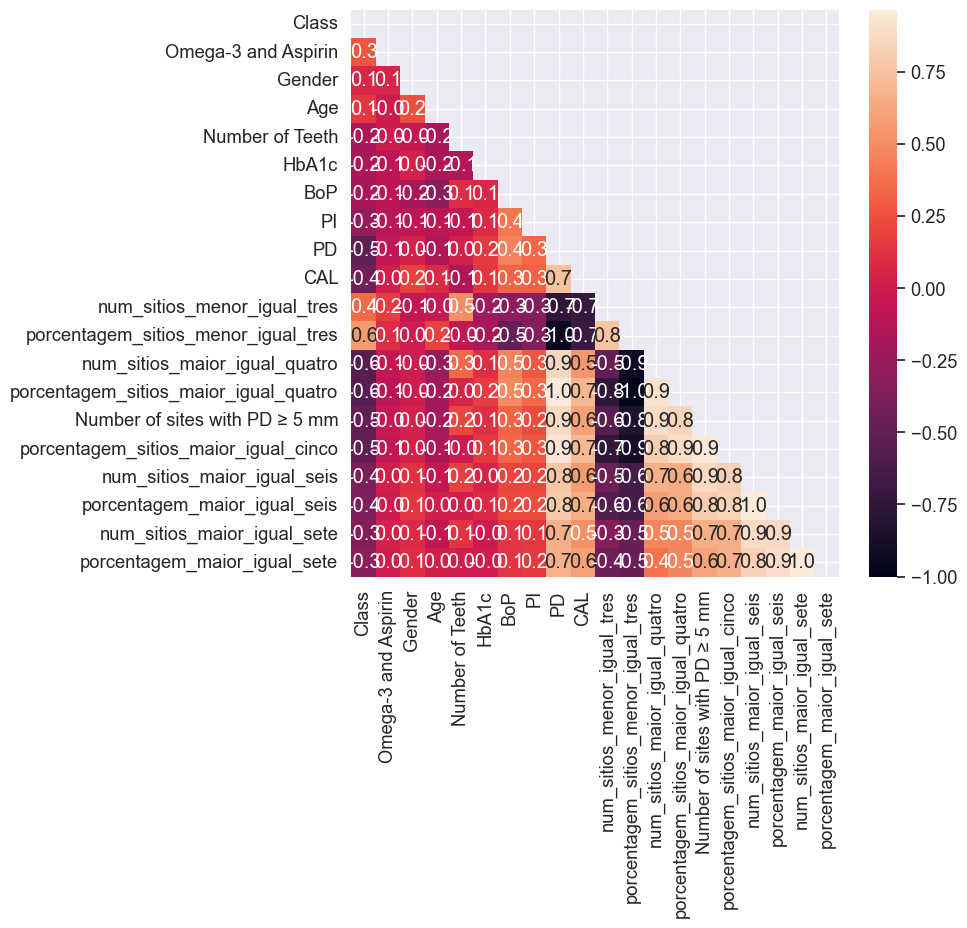

In [18]:
# Calcular correlação dos dados
matriz_correlacao = new_df.corr()
mask = np.triu(matriz_correlacao)
plt.figure(figsize=(7,7))
sns.heatmap(matriz_correlacao, mask = mask, annot = True, fmt = ".1f")

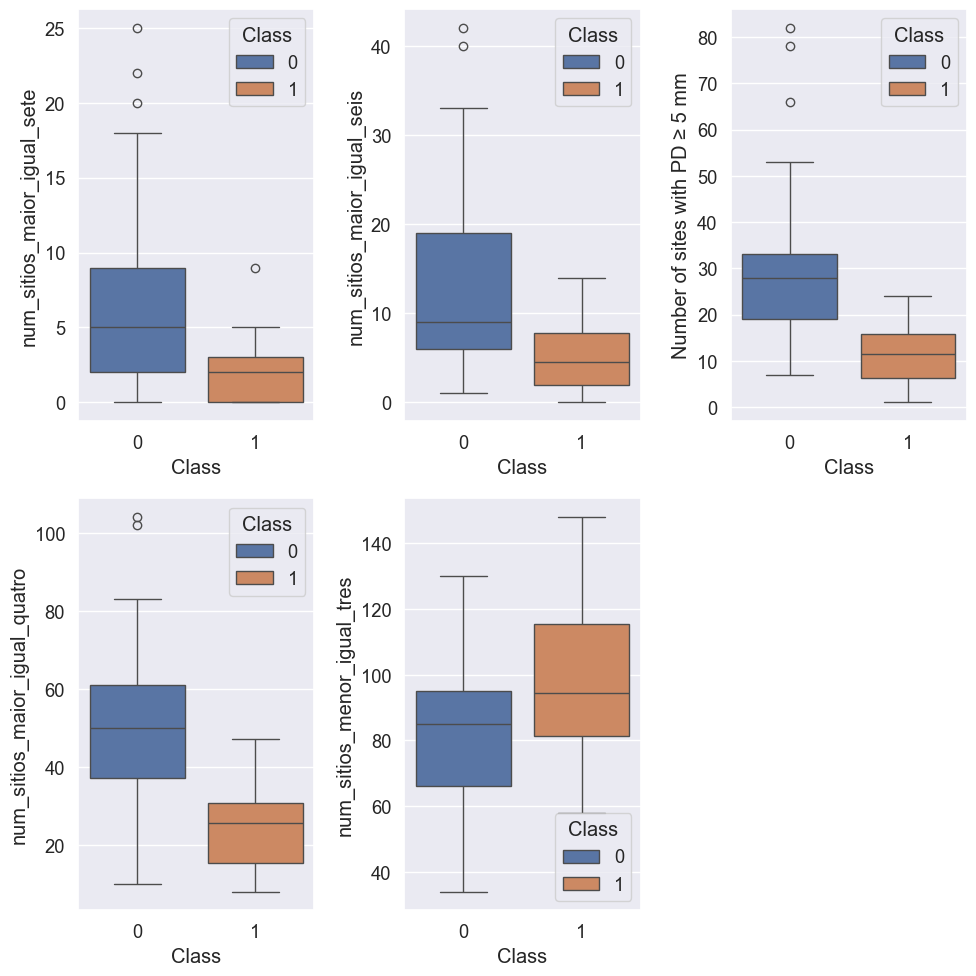

In [19]:
# Verificando a distribuição do número de sítios com a classe
plt.figure(figsize=(10,10))

plt.subplot(2,3,1)
sns.boxplot(data = new_df, x = 'Class', y = 'num_sitios_maior_igual_sete', hue='Class')

plt.subplot(2,3,2)
sns.boxplot(data = new_df, x = 'Class', y = 'num_sitios_maior_igual_seis', hue='Class')

plt.subplot(2,3,3)
sns.boxplot(data = new_df, x = 'Class', y = "Number of sites with PD ≥ 5 mm", hue='Class')

plt.subplot(2,3,4)
sns.boxplot(data = new_df, x = 'Class', y = 'num_sitios_maior_igual_quatro', hue='Class')

plt.subplot(2,3,5)
sns.boxplot(data = new_df, x = 'Class', y = 'num_sitios_menor_igual_tres', hue='Class')

plt.tight_layout()
#plt.savefig('classe por num_sitios.png')


O *endpoint* clínico de tratamento é quando há, no máximo, 4 bolsas periodontais com profundidade de sondagem $\leq$ 4 mm. O número de sítios é dado por quantas bolsas periodontais o paciente possui na boca toda. Em cada dente foram medidos 6 locais (sítios) e somou-se todas as bolsas que o paciente tem em todos os dentes. Portanto, o número de sítios, como pode ser visto nos boxplots acima, não determinam um desfecho positivo.

## 2.2 Análise Exploratória

**Lista de Siglas** <br>
<br>
HbA1c -> níveis de hemoglobina glicada (%)<br>
SS    -> sangramento à sondagem <br>
IP    -> presença de biofilme supragengival <br>
PS    -> profundidade de sondagem <br>
NIC   -> nível clínico de inserção.

In [20]:
# Características gerais da população do estudo
new_df.describe()

,Class,Omega-3 and Aspirin,Gender,Age,Number of Teeth,HbA1c,BoP,PI,PD,CAL,num_sitios_menor_igual_tres,porcentagem_sitios_menor_igual_tres,num_sitios_maior_igual_quatro,porcentagem_sitios_maior_igual_quatro,Number of sites with PD ≥ 5 mm,porcentagem_sitios_maior_igual_cinco,num_sitios_maior_igual_seis,porcentagem_maior_igual_seis,num_sitios_maior_igual_sete,porcentagem_maior_igual_sete
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.00000,75.000000,75.0000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,0.293333,0.666667,0.400000,55.040000,21.533333,8.151077,46.588400,55.280933,3.258920,3.801503,86.120000,67.076312,42.44000,32.923688,24.0800,18.805958,10.680000,8.399824,5.266667,4.187435
std,0.458356,0.474579,0.493197,9.189359,3.863668,1.544209,19.328709,17.336556,0.511682,0.763957,24.212996,14.761091,20.92925,14.761091,16.2004,11.738049,9.445663,6.924214,5.714688,4.343769
min,0.000000,0.000000,0.000000,38.000000,15.000000,6.500000,8.900000,13.890000,2.410714,2.568182,34.000000,29.166667,8.00000,5.128205,1.0000,0.641026,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,47.000000,18.000000,6.750000,33.660000,49.265000,2.919792,3.169643,69.000000,57.518797,26.00000,21.854414,12.0000,10.000000,4.000000,3.496503,1.000000,0.793651
50%,0.000000,1.000000,0.000000,56.000000,22.000000,7.900000,48.000000,53.700000,3.173913,3.730159,88.000000,67.333333,41.00000,32.666667,21.0000,17.424242,8.000000,6.349206,4.000000,3.125000
75%,1.000000,1.000000,1.000000,62.000000,25.000000,9.080000,59.880000,63.915000,3.577352,4.246528,99.500000,78.145586,54.50000,42.481203,30.5000,23.721228,13.500000,10.690476,7.000000,5.255682
max,1.000000,1.000000,1.000000,74.000000,28.000000,12.040000,100.000000,100.000000,4.562500,5.657407,148.000000,94.871795,104.00000,70.833333,82.0000,56.944444,42.000000,27.777778,25.000000,17.708333


In [21]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Class                                  75 non-null     int64  
 1   Omega-3 and Aspirin                    75 non-null     int64  
 2   Gender                                 75 non-null     int64  
 3   Age                                    75 non-null     int64  
 4   Number of Teeth                        75 non-null     int64  
 5   HbA1c                                  75 non-null     float64
 6   BoP                                    75 non-null     float64
 7   PI                                     75 non-null     float64
 8   PD                                     75 non-null     float64
 9   CAL                                    75 non-null     float64
 10  num_sitios_menor_igual_tres            75 non-null     int64  
 11  porcenta

Os pacientes foram divididos em 3 grupos (Grupo Controle, Grupo Teste 1 e Grupo Teste 2). Dessa maneira, 50 pacientes tomaram $\omega$-3.

Como já apresentado na Seção 2.1, o conjunto de dados para desenvolvimento desse trabalho é desbalanceada. Todavia, como os pacientes são distribuídos em gêneros, nesse caso Masculino e Feminino, buscou-se entender como os gêneros estão distribuídos perante ao atributo alvo. Dessa forma, há 45 pacientes do gênero feminino das quais 63.33% não alcançaram o *endpoint* clínico. Tendo em vista o gênero masculino, a base de dados possuem 30 homens, dentre eles, 73.33% também não alcançaram a meta clínica de tratamento. Esta proporção é ilustrada no gráfico abaixo.

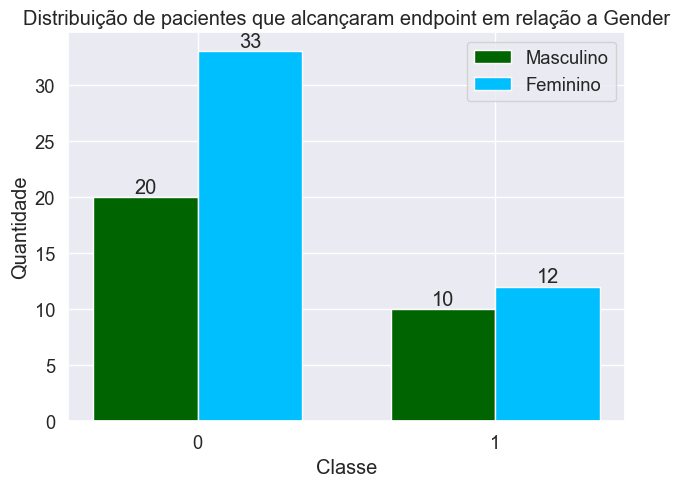

In [22]:
plot_qualitative_att(new_df, 'Gender', 'Feminino', 'Masculino')

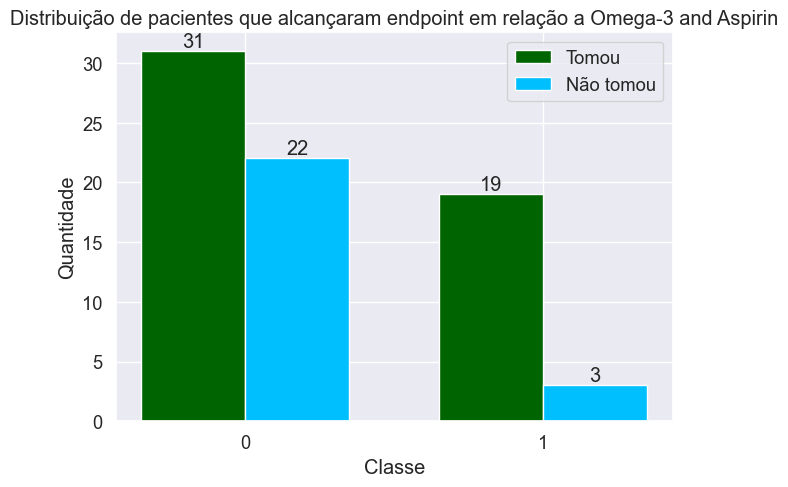

In [23]:
plot_qualitative_att(new_df, 'Omega-3 and Aspirin', 'Não tomou', 'Tomou')

In [24]:
new_df[new_df.Class == 1].iloc[:, 3:].describe()

,Age,Number of Teeth,HbA1c,BoP,PI,PD,CAL,num_sitios_menor_igual_tres,porcentagem_sitios_menor_igual_tres,num_sitios_maior_igual_quatro,porcentagem_sitios_maior_igual_quatro,Number of sites with PD ≥ 5 mm,porcentagem_sitios_maior_igual_cinco,num_sitios_maior_igual_seis,porcentagem_maior_igual_seis,num_sitios_maior_igual_sete,porcentagem_maior_igual_sete
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,57.136364,20.500000,7.746818,41.633182,47.959545,2.845642,3.290430,99.500000,79.802003,24.590909,20.197997,11.681818,9.790735,4.954545,4.383816,2.227273,2.018770
std,7.356859,4.217311,1.374736,20.287857,14.774323,0.280007,0.477496,24.893583,9.146812,11.270100,9.146812,6.167398,5.583028,3.993772,3.818588,2.328536,2.238636
min,44.000000,16.000000,6.500000,9.720000,13.890000,2.410714,2.576923,58.000000,60.416667,8.000000,5.128205,1.000000,0.641026,0.000000,0.000000,0.000000,0.000000
25%,52.250000,17.000000,6.500000,25.240000,43.015000,2.580495,2.926992,81.250000,73.846726,15.250000,12.359944,6.250000,5.701754,2.000000,1.364522,0.000000,0.000000
50%,57.000000,19.500000,7.410000,42.420000,50.000000,2.872878,3.209325,94.500000,79.270833,25.500000,20.729167,11.500000,9.710145,4.500000,4.044118,2.000000,1.410935
75%,62.000000,24.000000,8.610000,56.817500,53.907500,3.035714,3.649050,115.500000,87.640056,30.750000,26.153274,15.750000,12.500000,7.750000,5.357143,3.000000,2.941176
max,70.000000,28.000000,11.800000,74.000000,88.000000,3.291667,4.205882,148.000000,94.871795,47.000000,39.583333,24.000000,21.052632,14.000000,12.280702,9.000000,8.333333


In [25]:
new_df.loc[(new_df.Class == 1) & (new_df.HbA1c == 10.07)].iloc[:, 3:10]

,Age,Number of Teeth,HbA1c,BoP,PI,PD,CAL


In [26]:
new_df[new_df.Class == 0].iloc[:, 3:].describe()

,Age,Number of Teeth,HbA1c,BoP,PI,PD,CAL,num_sitios_menor_igual_tres,porcentagem_sitios_menor_igual_tres,num_sitios_maior_igual_quatro,porcentagem_sitios_maior_igual_quatro,Number of sites with PD ≥ 5 mm,porcentagem_sitios_maior_igual_cinco,num_sitios_maior_igual_seis,porcentagem_maior_igual_seis,num_sitios_maior_igual_sete,porcentagem_maior_igual_sete
count,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000
mean,54.169811,21.962264,8.318882,48.645283,58.320000,3.430470,4.013646,80.566038,61.793949,49.849057,38.206051,29.226415,22.548126,13.056604,10.066846,6.528302,5.087636
std,9.781725,3.663554,1.591342,18.727994,17.534855,0.488537,0.762953,21.837256,13.391494,19.527492,13.391494,16.312621,11.611535,10.044928,7.258402,6.225270,4.691641
min,38.000000,15.000000,6.500000,8.900000,14.100000,2.421569,2.568182,34.000000,29.166667,10.000000,9.803922,7.000000,6.818182,1.000000,0.641026,0.000000,0.000000
25%,45.000000,19.000000,6.860000,36.360000,50.000000,3.122222,3.351852,66.000000,51.515152,37.000000,29.166667,19.000000,13.725490,6.000000,4.901961,2.000000,1.515152
50%,55.000000,22.000000,8.250000,48.530000,56.250000,3.442308,3.960317,85.000000,62.345679,50.000000,37.654321,28.000000,20.370370,9.000000,7.843137,5.000000,3.921569
75%,61.000000,25.000000,9.250000,62.040000,67.650000,3.715686,4.484127,95.000000,70.833333,61.000000,48.484848,33.000000,28.947368,19.000000,15.432099,9.000000,6.521739
max,74.000000,28.000000,12.040000,100.000000,100.000000,4.562500,5.657407,130.000000,90.196078,104.000000,70.833333,82.000000,56.944444,42.000000,27.777778,25.000000,17.708333


Pacientes que alcançaram o *endpoint* de tratamento, tem, em média, 57 $\pm$ 7 anos de idade com um intervalo de idade variando entre 44 à 70 anos. Em contrapartida, os pacientes que não alçaram o *endpoint* possuem, em média, 54 $\pm$ 10 anos e o intervalo de idade está entre 38 anos e 74 anos. A fim de visualizar a distribuição geral do atributo idade na base de dados, plotou-se um histograma e boxplot.

Como é apresentado por meio do boxplot, não há *outliers* para o atributo idade, não sendo necessário um pré-processamento neste atributo. Além disso, calculou-se a assimetria da variável idade. Esta por sua vez, mede a simetria da distribuição em torno da média.

## Assimetria
É o grau de desvio ou afastamento da simetria de uma distribuição.
Quando a curva é simétrica, a média, a mediana e a moda coincidem,
num mesmo ponto, de ordenada máxima, havendo um perfeito equilíbrio
na distribuição. Quando o equilíbrio não acontece, isto é, a média, a mediana e a moda recaem em pontos diferentes da distribuição esta será
assimétrica; enviesada a direita ou esquerda.

<ul>
<li> > 0: positiva quando os valores se concetram na extremidade inferior da escala e se distribuem gradativamente à extremidade superior;  </li>
<li> < 0: negativa é quando os valores se concetram na extremidade superior da escala e se distribuem gradativamente em direção à extremidade inferior;
<li> = 0, é simétrica (média = moda = mediana)
</ul>

## Curtose
É o grau de achatamento de uma distribuição, em relação a distribuição normal. A curtose pode ser de três tipos:
<ul>
<li> Mesocúrtica (= 0) - quando a distribuição é normal.</li>
<li> Leptocúrtica (> 0)- quando a distribuição é mais pontiaguda que a normal</li>
<li> Platicúrtica (< 0) - quando a distribuição é mais achatada que a normal.</li>
</ul>

Fonte: https://cesad.ufs.br/ORBI/public/uploadCatalago/09215427022012Bioestatistica_Aula_03.pdf

Assimetria de Age: -0.04621187619655849
Curtose de Age: -0.9725744935390988


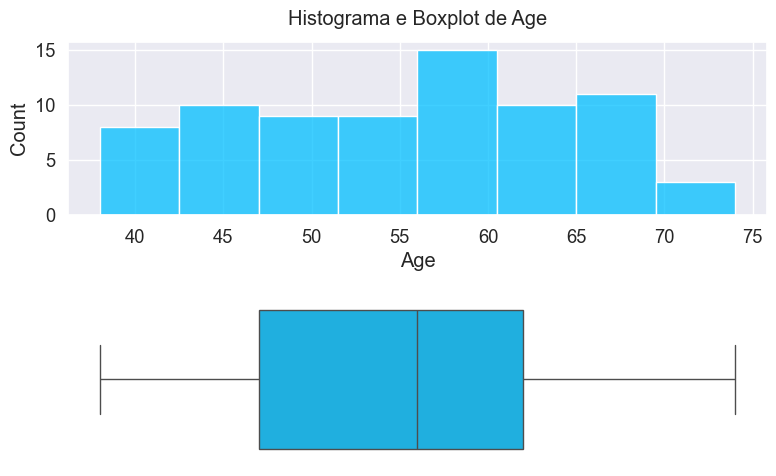

In [27]:
my_info_graphic(new_df, "Age")


Ainda, os pacientes que não alcaçaram o *endpoint* possuem, em média, 1 dente a mais que os pacientes com a classe positiva. Para este atributo, também plotou-se o histograma e boxplot. Observa-se que também não *outliers* neste atributo. Além disso, a maior frequência do número de dentes na base de todos é com 17 dentes. Segundo o site da Colgate, o número de dentes de um adulto saudável é 32 dentes. Dessa maneira, pode-se observar que os pacientes da base de dados já possuem menos dentes que a média de um adulto saudável.

Referência: https://www.colgate.com.br/oral-health/mouth-and-teeth-anatomy/how-many-teeth-do-we-have

Assimetria de Number of Teeth: -0.028607919424394078
Curtose de Number of Teeth: -1.2620688223440066


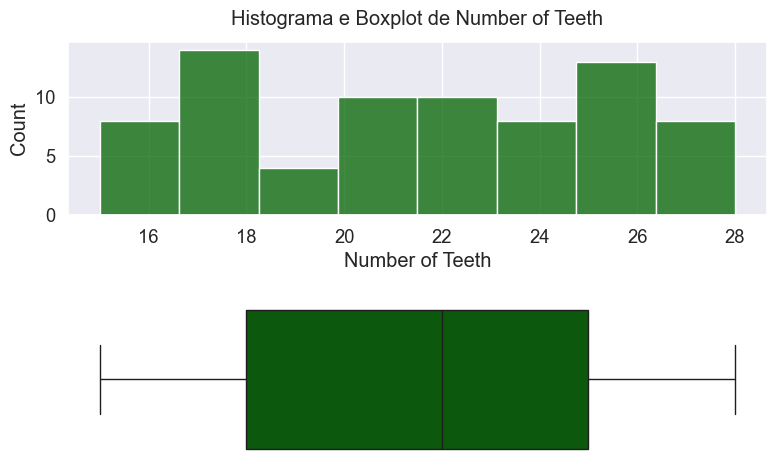

In [28]:
my_info_graphic(new_df, "Number of Teeth")


Como o trabalho de dosSantos (2019) trabalha com um estudo clínico randomizado, os critérios de inclusão de pacientes foram:

<li> Ter 35 anos ou mais;
<li> Ser portador de diabetes diagnosticada há mais de cinco anos;
<li> Realizar tratamento para diabetes com dieta e suplementação de insulina ou de agentes hipoglicemiantes orais;
<li> Apresentar níveis de hemoglobina glicada (HbA1c) ≥ 6,5% e ≤ 11%;
<li> Ter pelo menos 15 dentes, excluindo terceiros molares e dentes indicados para extração;
<li> Apresentar periodontite crônica generalizada moderada a avançada (AAP, 1999) com pelo menos 30% dos sítios com profundidade de sondagem (PS) e nível clínico de inserção (NIC) ≥ 4mm e sangramento à sondagem no baseline (Duarte et al., 2014);

Dessa forma, os atributos do conjunto de dados vão possuir essas características, devido aos critérios de inclusão de pacientes no estudo dosSantos (2019).


Como HbA1c é um exame para avaliar a influência dos tratamentos no controle de diabetes, se a glicose em jejum for maior ou igual a 126mg/dl ou o exame de HbA1c for maior igual a 6,5%, há suspeita de diabetes. Portanto, como o grupo de estudo do trabalho de dosSantos(2019) é em pacientes com Diabetes tipo 2, o range esperado é maior que 6.5%.


Segundo dosSantos(2019), os parâmetros de profundidade de sondagem, NIC, sangramento à sondagem e presença de biofilme supragengival foram avaliados utilizando-se uma sonda periodontal. Para estes atributos em questão há *outliers*. Contudo, são valores aceitáveis para a característica do atributo.

Os boxplots a seguir são para a base de dados após o tratamento dos *outlier* presente no atributo HbA1c.



Intervalo interquartil para o atributo HbA1c dado o desfecho positivo = 2.11
Intervalo interquartil para o atributo HbA1c dado o desfecho negativo = 2.39
--------------------
Moda para pacientes com desfecho positivo 
 0    6.5
Name: HbA1c, dtype: float64
Moda para pacientes com desfecho negativo 
 0    6.5
Name: HbA1c, dtype: float64
--------------------
Mediana para pacientes com desfecho positivo 7.41
Mediana para pacientes com desfecho negativo 8.25
--------------------
Média para pacientes com desfecho positivo 7.746818181818182
Média para pacientes com desfecho negativo 8.3188824383164


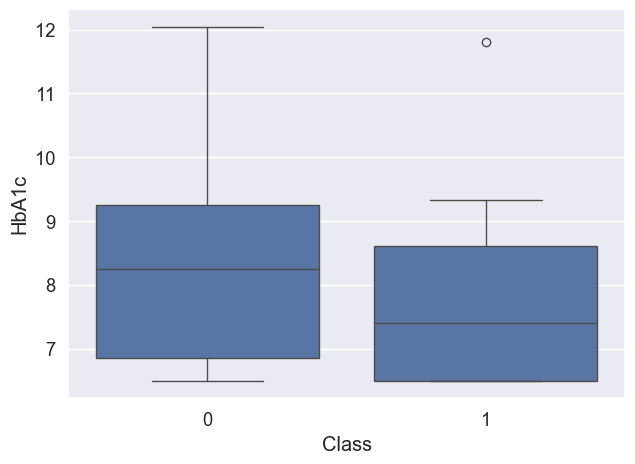

In [29]:
hba1c_positivo = np.sort(new_df[new_df.Class == 1].HbA1c)
q1 = np.percentile(hba1c_positivo, 25)
q3 = np.percentile(hba1c_positivo, 75)
print(f'Intervalo interquartil para o atributo HbA1c dado o desfecho positivo = {q3 - q1:.2f}')

hba1c_negativo = np.sort(new_df[new_df.Class == 0].HbA1c)
q1 = np.percentile(hba1c_negativo, 25)
q3 = np.percentile(hba1c_negativo, 75)
print(f'Intervalo interquartil para o atributo HbA1c dado o desfecho negativo = {q3 - q1:.2f}')
print('-'*20)
# Moda dos pacientes
print('Moda para pacientes com desfecho positivo \n', new_df[new_df.Class == 1].HbA1c.mode())
print('Moda para pacientes com desfecho negativo \n', new_df[new_df.Class == 0].HbA1c.mode())
print('-'*20)
print('Mediana para pacientes com desfecho positivo', new_df[new_df.Class == 1].HbA1c.median())
print('Mediana para pacientes com desfecho negativo', new_df[new_df.Class == 0].HbA1c.median())
print('-'*20)
print('Média para pacientes com desfecho positivo', new_df[new_df.Class == 1].HbA1c.mean())
print('Média para pacientes com desfecho negativo', new_df[new_df.Class == 0].HbA1c.mean())

sns.boxplot(data = new_df, x = 'Class', y = 'HbA1c')
plt.show()

In [30]:
new_df.loc[(new_df.HbA1c >= 9.4) & (new_df.Class == 0)]

,Class,Omega-3 and Aspirin,Gender,Age,Number of Teeth,HbA1c,BoP,PI,PD,CAL,num_sitios_menor_igual_tres,porcentagem_sitios_menor_igual_tres,num_sitios_maior_igual_quatro,porcentagem_sitios_maior_igual_quatro,Number of sites with PD ≥ 5 mm,porcentagem_sitios_maior_igual_cinco,num_sitios_maior_igual_seis,porcentagem_maior_igual_seis,num_sitios_maior_igual_sete,porcentagem_maior_igual_sete
5,0,1,0,47,22,11.530000,8.90,51.80,2.973333,3.166667,113,75.333333,37,24.666667,26,17.333333,16,10.666667,6,4.000000
8,0,1,1,69,28,10.020000,36.80,51.30,4.260417,5.572917,47,48.958333,49,51.041667,34,35.416667,24,25.000000,17,17.708333
11,0,1,1,64,17,9.890000,68.05,68.05,4.212963,5.657407,53,49.074074,55,50.925926,40,37.037037,25,23.148148,12,11.111111
19,0,1,0,45,20,11.830000,56.25,67.50,3.611111,4.460317,70,55.555556,56,44.444444,29,23.015873,8,6.349206,3,2.380952
33,0,1,0,60,17,10.230769,65.50,72.60,3.533333,4.425000,76,63.333333,44,36.666667,22,18.333333,11,9.166667,7,5.833333
44,0,1,0,38,26,10.480000,50.96,46.15,3.262821,3.493590,91,58.333333,65,41.666667,19,12.179487,3,1.923077,1,0.641026
55,0,0,0,43,26,9.440000,88.00,100.00,3.416667,4.030864,88,56.410256,68,43.589744,28,17.948718,5,3.205128,0,0.000000
57,0,0,0,41,21,10.200000,100.00,100.00,4.333333,3.416667,50,39.682540,76,60.317460,53,42.063492,24,19.047619,14,11.111111
60,0,0,0,61,24,11.670000,33.70,21.74,3.055556,3.076389,103,71.527778,41,28.472222,26,18.055556,12,8.333333,5,3.472222
65,0,0,0,74,17,10.700000,32.35,54.42,3.000000,3.686275,75,73.529412,27,26.470588,14,13.725490,8,7.843137,2,1.960784


In [31]:
# Tabela de frequência do atributo HbA1c para os 23 pacientes que alcançaram o endpoint

# dos 23 pacientes que tiveram classe positiva -> 18 pacientes com HbA1c ≤ 9.0%
# dos 52 pacientes que tiveram classe negaiva -> 15 pacientes com HbA1c >= 9.0%

tabela_freq_hba1c = new_df[new_df.Class == 1].HbA1c.value_counts().reset_index()
tabela_freq_hba1c.columns = (["Valor de HbA1c","Quantidade de pacientes"])
display(tabela_freq_hba1c[tabela_freq_hba1c['Valor de HbA1c']>= 9.0])

,Valor de HbA1c,Quantidade de pacientes
6,11.80,1
9,9.20,1
10,9.33,1
11,9.30,1


Assimetria de HbA1c: 0.8220441891266499
Curtose de HbA1c: -0.06463183634103009


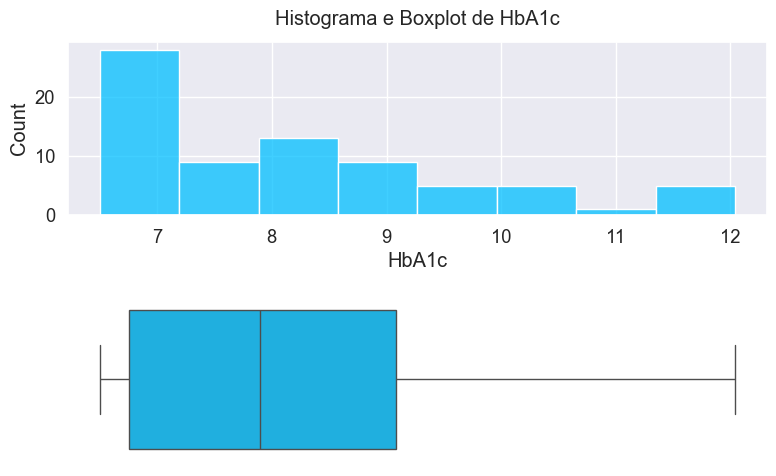

Assimetria de BoP: 0.10848078072090493
Curtose de BoP: -0.1711753621016343


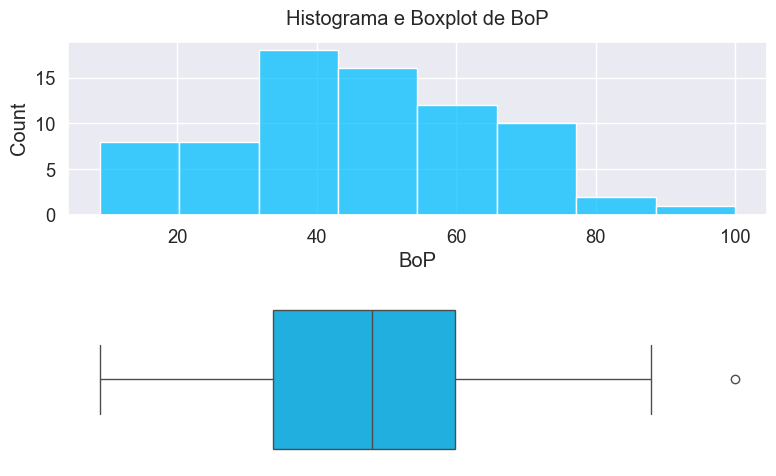

Assimetria de PI: 0.3314942292418347
Curtose de PI: 1.0507741920967324


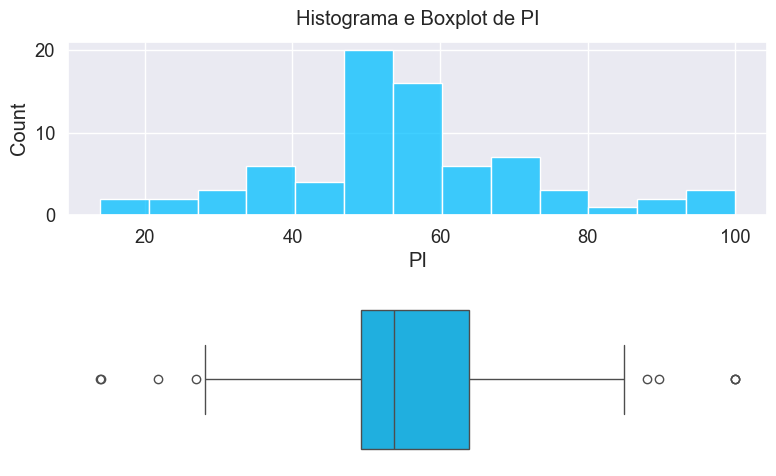

Assimetria de PD: 0.4645383644611219
Curtose de PD: -0.3103821610978601


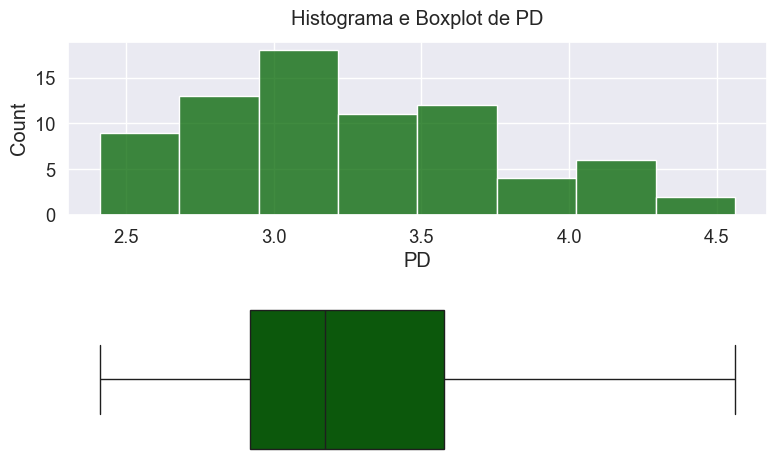

Assimetria de CAL: 0.5496230308613608
Curtose de CAL: -0.31147304425980593


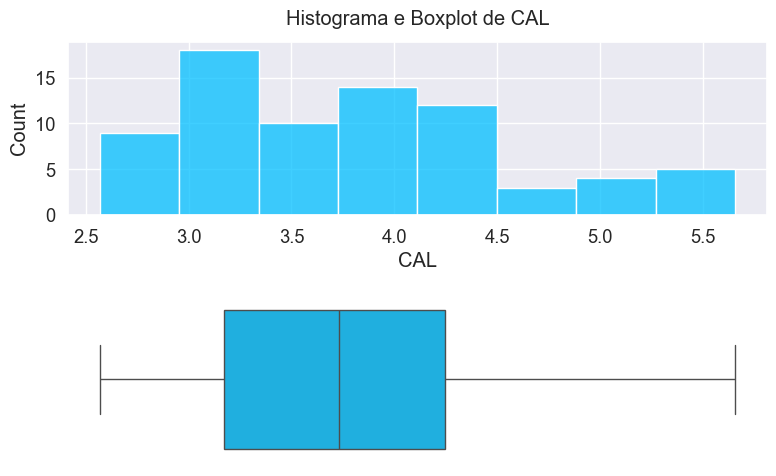

In [32]:
my_info_graphic(new_df, "HbA1c")

my_info_graphic(new_df, "BoP")

my_info_graphic(new_df, "PI")

my_info_graphic(new_df, "PD")

my_info_graphic(new_df, "CAL")

Assimetria de num_sitios_menor_igual_tres: 0.31811729006277195
Curtose de num_sitios_menor_igual_tres: 0.16186130012885336


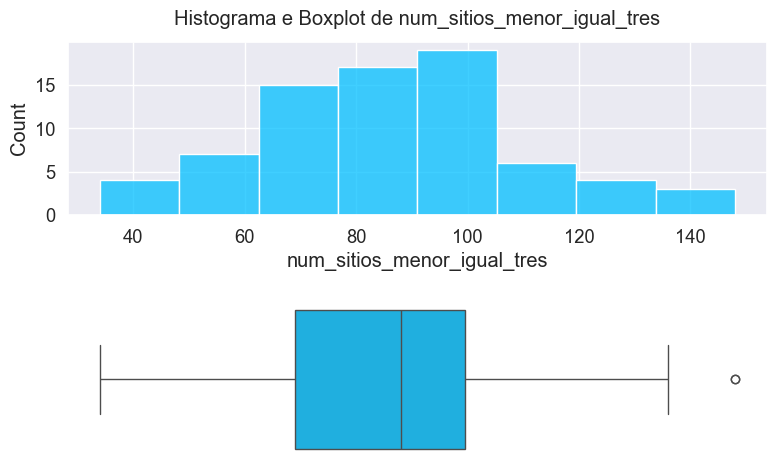

Assimetria de num_sitios_maior_igual_quatro: 0.600556719281168
Curtose de num_sitios_maior_igual_quatro: 0.35954874275883286


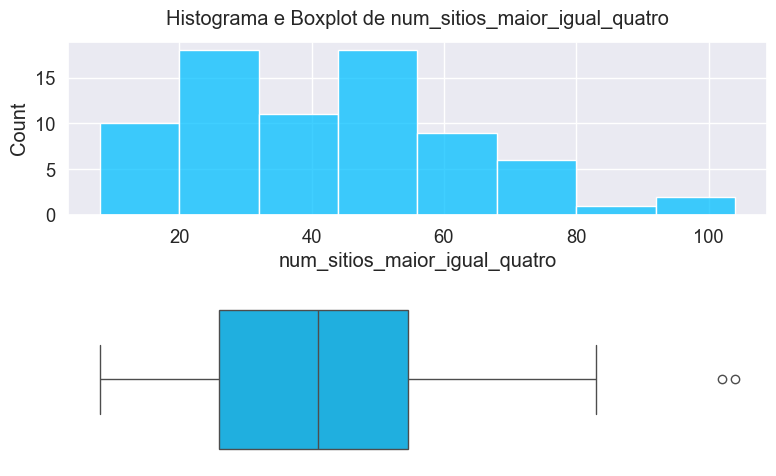

Assimetria de Number of sites with PD ≥ 5 mm: 1.4499737374387296
Curtose de Number of sites with PD ≥ 5 mm: 2.6788297210971597


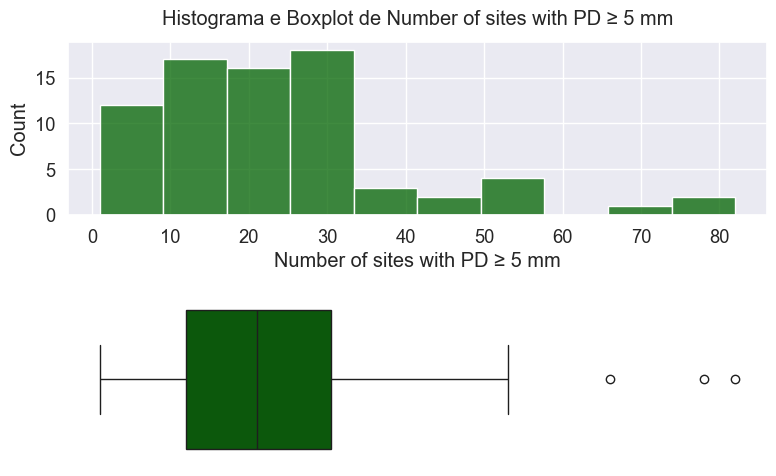

Assimetria de num_sitios_maior_igual_seis: 1.4209935312201738
Curtose de num_sitios_maior_igual_seis: 1.7430289691893912


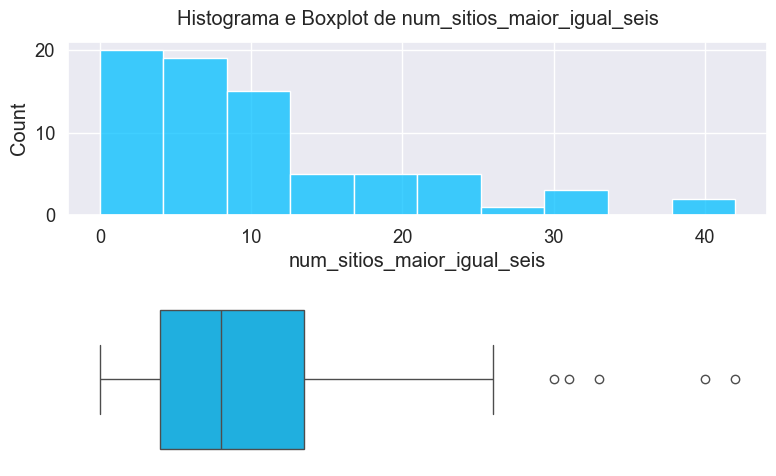

Assimetria de num_sitios_maior_igual_sete: 1.5657570663793232
Curtose de num_sitios_maior_igual_sete: 2.1397545846594883


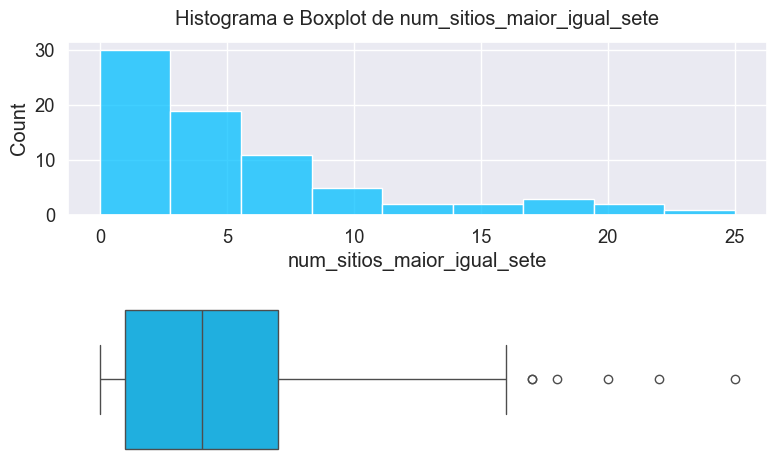

In [33]:
my_info_graphic(new_df, "num_sitios_menor_igual_tres")

my_info_graphic(new_df, "num_sitios_maior_igual_quatro")

my_info_graphic(new_df, "Number of sites with PD ≥ 5 mm")

my_info_graphic(new_df, "num_sitios_maior_igual_seis")

my_info_graphic(new_df, "num_sitios_maior_igual_sete")

Uma vez que há a tendência de adultos com idade avançada começar a perder os dentes, buscou-se visualizar como é a distribuição desses dois atributos nos pacientes do estudo. Como é apresentado na figura a seguir, não há uma relação entre o número de dentes, idade e ter alcançado ou não o *endpoint* de tratamento.

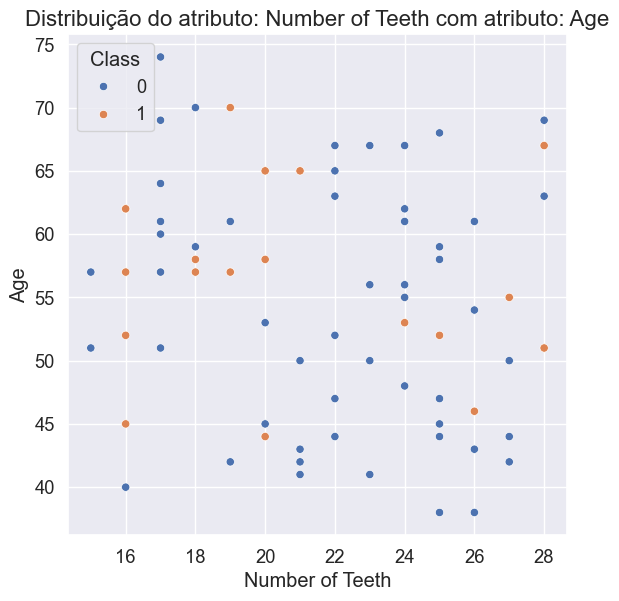

In [34]:
my_scatterplot(new_df, "Number of Teeth", "Age")

Por meio do gráfico abaixo, pode-se visualizar que pacientes que, apenas, 5 pacientes com resultado do exame de HbA1c maior que 10% alcançaram o *endpoint* clínico de tratamento. Ainda, 11 dos 23 pacientes que alcançarm o endpoint possuem 22 dentes ou menos.

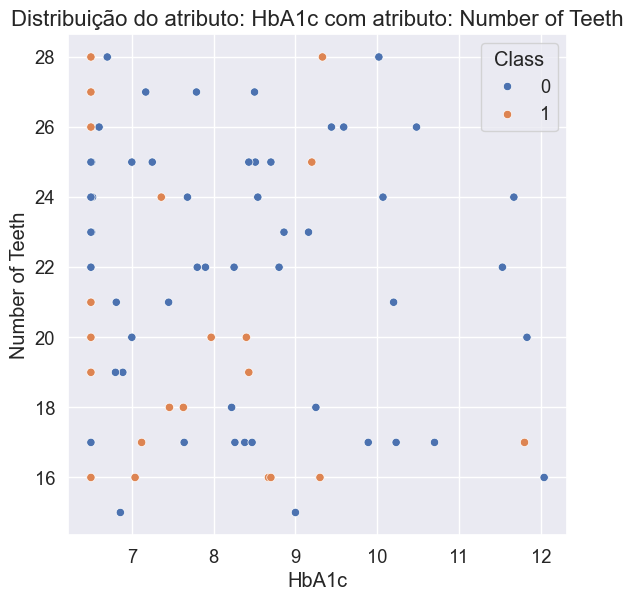

In [35]:
my_scatterplot(new_df, "HbA1c", "Number of Teeth")

A partir da análise anterior do resultado do HbA1c, buscou-se visualizar a distribuição dos pontos, de maneira bidimensional, visando encontrar um padrão. Dessa maneira, pacientes com baixos valores de profundidade de sondagem e resultado de HbA1c menor que 9% alcançaram o *endpoint* clínico de tratamento. O mesmo ocorre para o atributo NIC.

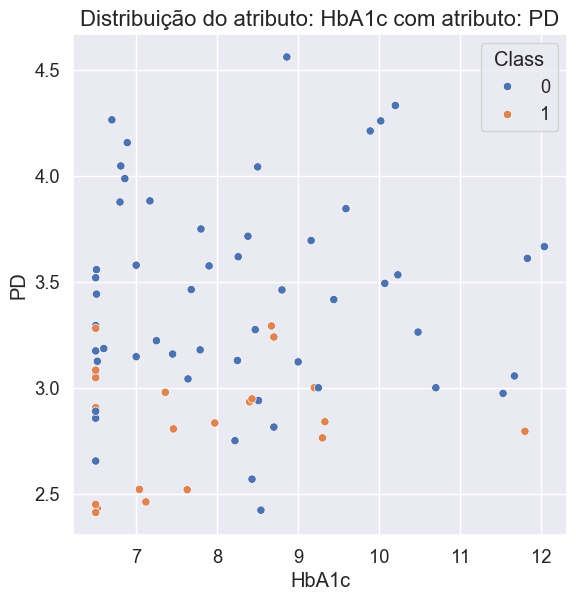

In [36]:
my_scatterplot(new_df, "HbA1c", "PD")

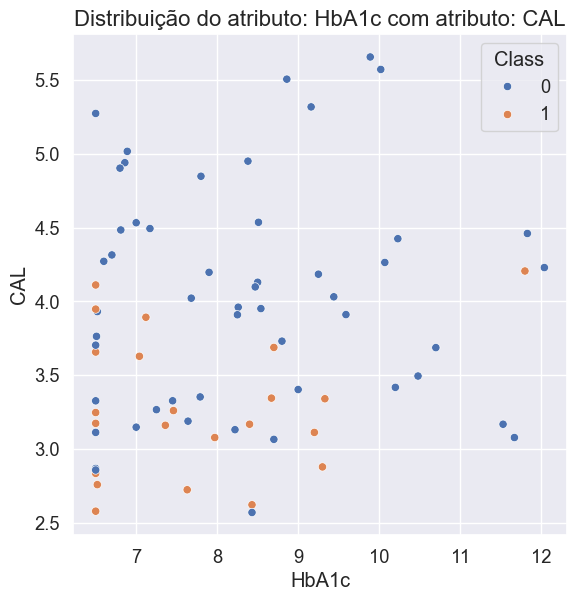

In [37]:
my_scatterplot(new_df, "HbA1c", "CAL")

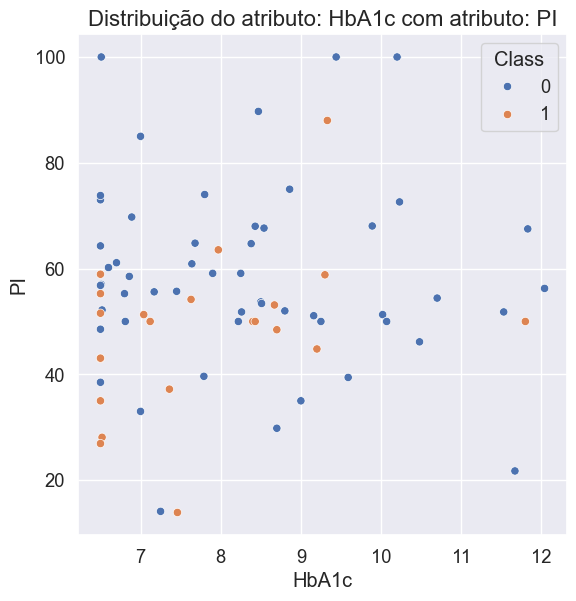

In [38]:
my_scatterplot(new_df, "HbA1c", "PI")

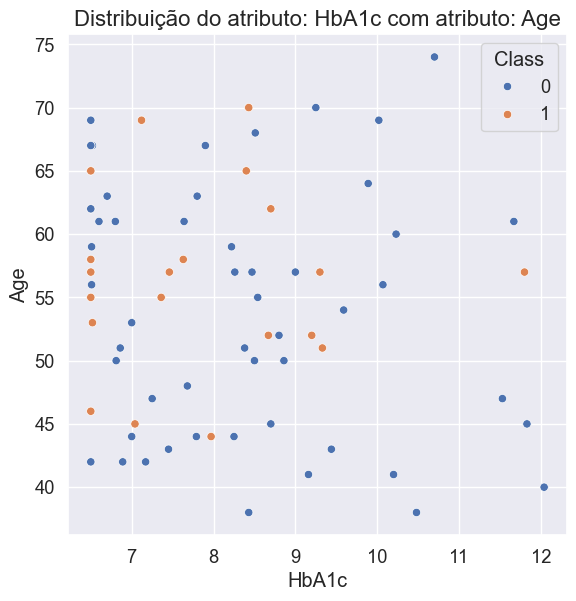

In [39]:
my_scatterplot(new_df, "HbA1c", "Age")

Por fim, contatou-se que para os pacientes que obtiveram no máximo 33 sítios com profundidade de sondagem maiores iguais a 5 mm alcançaram o *endponint*.

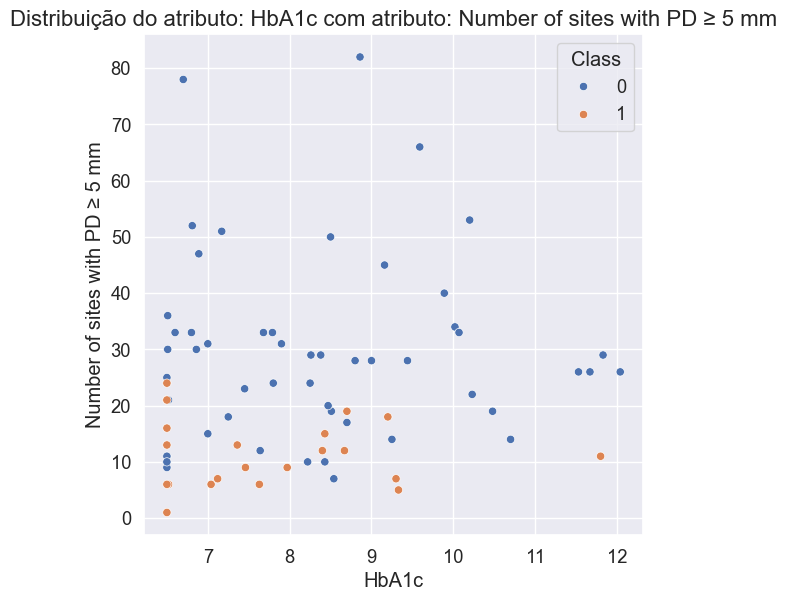

In [40]:
my_scatterplot(new_df, "HbA1c", "Number of sites with PD ≥ 5 mm")

## 2.4 Modelos

Com os dados preparados, os modelos utilizados no presente trabalho foram: Regressão Logística, *K-Nearest Neighboors, Decison Tree, Support Vector Machine, Random Forest* da biblioteca *Scikit-learn* e os algoritmos *XGBoost* e *Catboost*. Todos os algoritmos são bem consolidados na literatura.

A base de dados do presente trabalho é desbalanceada quanto à classe e possui, apenas, 75 objetos. Portanto, a metodologia escolhida para desenvolver um estimador foi utilizar a técnica de amostragem *Leave-one-out*. Tal técnica é uma validação cruzada utilizando 74 objetos de treinamento e 1 para teste, caracterizando um fold; isto se repete até que todas as observações tenham sido utlizadas como teste. Para cada fold, utilizou-se a técnica de *oversampling Synthetic Minority Oversampling Technique* (SMOTE), a qual cria dados sintéticos para a clase minoritária até que a base se torna balanceada. Ainda, cada fold teve seus parâmetros otimizados por meio da busca em grade (*Grid Search*) e teve as probabilidades calibradas com a função CalibratedClassiferCV.

O objetivo de desenvolver o modelo preditivo para essa base de dados é conseguir predizer se o paciente, a partir dos atributos em questão, alcançará o *endpoint* clínico de tratamento. Para a avaliação dos modelos utilizou-se as métricas: Acurácia, Sensibilidade, Especificidade e AUC (*Area Under Curve*). Além de visualizar a matriz de confusão para cada modelo treinado no trabalho.


# 3. Resultados e Discussão

Uma vez que a análise exploratória foi realizada, assim como, o pré-processamento da base de dados. Os dados precisam ser divididos nos atributos (X) e na classe (y). Em seguida, os dados foram normalizados utilizando a função *StandardScaler* da biblioteca *Scikit-learn*. Esta possui a finalidade de normalizar os atributos com média nula e variância unitária.

In [41]:
new_df.columns

Index(['Class', 'Omega-3 and Aspirin', 'Gender', 'Age', 'Number of Teeth',
       'HbA1c', 'BoP', 'PI', 'PD', 'CAL', 'num_sitios_menor_igual_tres',
       'porcentagem_sitios_menor_igual_tres', 'num_sitios_maior_igual_quatro',
       'porcentagem_sitios_maior_igual_quatro',
       'Number of sites with PD ≥ 5 mm',
       'porcentagem_sitios_maior_igual_cinco', 'num_sitios_maior_igual_seis',
       'porcentagem_maior_igual_seis', 'num_sitios_maior_igual_sete',
       'porcentagem_maior_igual_sete'],
      dtype='object')

In [42]:
# Retirando todas as variaveis que possuem número de sítios

new_df = new_df.drop(columns = ['num_sitios_menor_igual_tres',
       'porcentagem_sitios_menor_igual_tres', 'num_sitios_maior_igual_quatro',
       'porcentagem_sitios_maior_igual_quatro',
       'Number of sites with PD ≥ 5 mm',
       'porcentagem_sitios_maior_igual_cinco', 'num_sitios_maior_igual_seis',
       'porcentagem_maior_igual_seis', 'num_sitios_maior_igual_sete',
       'porcentagem_maior_igual_sete'])


In [43]:
new_df.head()

,Class,Omega-3 and Aspirin,Gender,Age,Number of Teeth,HbA1c,BoP,PI,PD,CAL
0,0,1,0,56,23,6.51,33.62,100.0,3.557971,3.760870
1,0,1,0,61,17,7.64,54.70,60.9,3.041667,3.187500
2,1,1,0,55,24,7.36,53.30,37.2,2.978261,3.159420
3,1,1,0,53,24,6.52,38.20,28.1,2.430556,2.756944
4,1,1,0,45,16,7.04,57.70,51.3,2.519608,3.627451


In [44]:
# Conjunto de dados sem a classe
X = new_df.drop(['Class'], axis= 1)

# Classe
y = new_df['Class']

In [45]:
X.columns

Index(['Omega-3 and Aspirin', 'Gender', 'Age', 'Number of Teeth', 'HbA1c',
       'BoP', 'PI', 'PD', 'CAL'],
      dtype='object')

## 3.1 KNN

KNN
----------------------------------------
Métricas de avaliação
----------------------------------------
Taxa de acerto total = 68.0000 % 
Taxa de erro total = 32.0000 %
Precisão = 46.1538 %
Revocação = 54.5455 %
Especificidade = 73.5849 %
F1-score = 50.0000 %
----------------------------------------


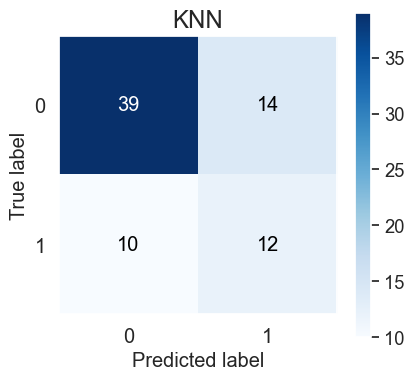

In [46]:
np.random.seed(42)
SEED = check_random_state(42)

knn = KNeighborsClassifier()

# Otimização de parametros
param_grid = {'n_neighbors': np.arange(1,10),
            'weights': ['uniform', 'distance']
            }

results_knn = RunModel(knn, X, y,confusion_matrix=True, roc_curve=False,title='KNN', parameters= param_grid)

## 3.2 Árvore de Decisão

Árvore de Decisão
----------------------------------------
Métricas de avaliação
----------------------------------------
Taxa de acerto total = 76.0000 % 
Taxa de erro total = 24.0000 %
Precisão = 60.0000 %
Revocação = 54.5455 %
Especificidade = 84.9057 %
F1-score = 57.1429 %
----------------------------------------


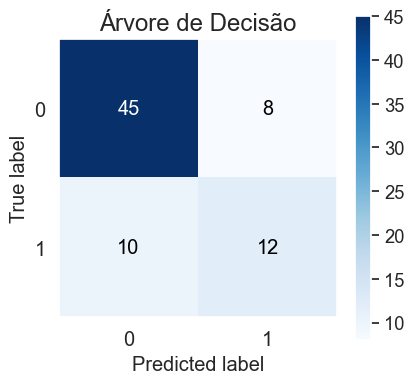

In [47]:
np.random.seed(42)
SEED = check_random_state(42)

tree = DecisionTreeClassifier(random_state=SEED)

# Otimização de parâmetros
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': [5, 10, 20],
            'random_state': [SEED]}

result_tree = RunModel(tree, X, y, parameters=param_grid,confusion_matrix=True, roc_curve=False, title = 'Árvore de Decisão')

## 3.3 Support Vector Machine

In [48]:
np.random.seed(42)
SEED = check_random_state(42)

svm = SVC(random_state=SEED, probability= True)

param_grid = {
     'C': [0.1, 1, 10],
     #'kernel': ['rbf'],
     'gamma': ['scale', 'auto'],
     'degree': [2, 3, 4]
}

results_svm = RunModel(svm, X, y, parameters=param_grid,confusion_matrix=True, roc_curve=False, title = 'Support Vector Machine')

KeyboardInterrupt: 

## 3.4 Random Forest

In [ ]:
np.random.seed(42)
SEED = check_random_state(42)

rf = RandomForestClassifier(random_state=SEED)


# Número de features a serem consideradas a cada split
max_features = ['log2', 'sqrt']
# Número máximo de níveis na árvore
max_depth = [5, 10, 20]
# Número mínimo de amostras necessárias para dividir um nó
min_samples_split = [2, 5]
# Número mínimo de amostras necessárias em cada leaf node
min_samples_leaf = [2, 4]
# Método de seleção das amostras para treinamento de cada árvore
bootstrap = [True, False]

# Criação do param grid
param_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'random_state' : [SEED]
              }


results_rf = RunModel(rf, X, y, parameters=param_grid, confusion_matrix=True, roc_curve=False, title = 'Random Forest')

## 3.5 XGBoosting

In [ ]:
np.random.seed(42)
SEED = check_random_state(42)

xg = xgb.XGBClassifier(random_state=SEED)

# Otimização de parâmetros
param_grid = {
    'max_depth': [3, 6, 9],
    'n_estimators': [100, 500, 1000],
    'eta': [0.01, 0.05, 0.1],
    'random_state': [SEED]

}

results_xg = RunModel(xg, X, y, confusion_matrix=True, roc_curve=False, parameters=param_grid, title = 'Algoritmo XGBoosting')

## 3.6 Regressão Logística

Regressão Logística
----------------------------------------
Métricas de avaliação
----------------------------------------
Taxa de acerto total = 80.0000 % 
Taxa de erro total = 20.0000 %
Precisão = 62.9630 %
Revocação = 77.2727 %
Especificidade = 81.1321 %
F1-score = 69.3878 %
----------------------------------------


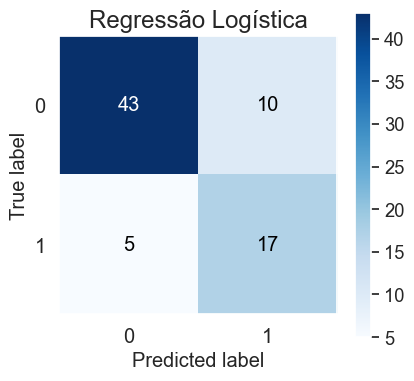

In [49]:
np.random.seed(42)
SEED = check_random_state(42)

lr = LogisticRegression(random_state = 42)

param_grid = {"solver": ["lbfgs"]}

results_regression = RunModel(lr, X, y, parameters=param_grid,confusion_matrix=True, roc_curve=False, title = 'Regressão Logística')

## 3.7 Catboost

In [ ]:
np.random.seed(42)
SEED = check_random_state(42)

ct = CatBoostClassifier(random_state = 42, silent = True, eval_metric='Logloss')

param_grid = {#"depth": [1, 2, 5, 10],
                "iterations": [100, 250, 500],
                "learning_rate": [0.001, 0.01, 0.1],
              }

results_cat = RunModel(ct, X, y, parameters=param_grid,confusion_matrix=True, roc_curve=False, title = 'Catboost')

## 3.8 Comparação dos modelos

In [ ]:
results = [["KNN", results_knn['acuracia'],results_knn['especificidade'],results_knn['sensibilidade'], results_knn["auc_score"]],
        ["Decison Tree", result_tree['acuracia'],result_tree['especificidade'],result_tree['sensibilidade'], result_tree["auc_score"]],
        ["SVM", results_svm['acuracia'],results_svm['especificidade'],results_svm['sensibilidade'], results_svm["auc_score"]],
        ["Random Forest", results_rf['acuracia'],results_rf['especificidade'],results_rf['sensibilidade'], results_rf["auc_score"]],
        ["XGBoost", results_xg['acuracia'],results_xg['especificidade'],results_xg['sensibilidade'], results_xg["auc_score"]],
        ["CatBoost", results_cat['acuracia'],results_cat['especificidade'],results_cat['sensibilidade'], results_cat["auc_score"]],
        ["Regression", results_regression['acuracia'],results_regression['especificidade'],results_regression['sensibilidade'], results_regression["auc_score"]]]




CompareResults(results, bar_plot=False)

In [ ]:
plot_roc = {
    'KNN': results_knn['probabilidades'],
    'Decision Tree': result_tree['probabilidades'],
    'Support Vector Machine': results_svm['probabilidades'],
    'Random Forest': results_rf['probabilidades'],
    'XGBoost': results_xg['probabilidades'],
    'CatBoost': results_cat['probabilidades'],
    'Regression':results_regression['probabilidades']
}

plt.figure(figsize=(5,5))

for modelo, preds in plot_roc.items():
    fpr, tpr, _ = metrics.roc_curve(y, [x[1] for x in preds])
    auc = metrics.roc_auc_score(y, [x[1] for x in preds])
    plt.plot(fpr, tpr, label=f'{modelo} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Linha de referência diagonal
plt.xlabel('False positive rate', fontsize = 10)
plt.ylabel('True positive rate', fontsize = 10)
#plt.title('Curva ROC - Comparação de Modelos', fontsize = 16)
plt.legend(loc='lower right', bbox_to_anchor=(1.2,0), prop={'size': 10})
plt.show()


Área Sob a Curva Característica de Operação do Receptor (ROC AUC) é uma métrica usada para avaliar o desempenho de modelos de aprendizado de máquina de classificação. O *score* AUC pode ser interpretado como a capacidade do modelo de classificar com precisão as classes em uma escala de 0 a 1, onde 1 é o melhor e 0,5 é tão bom quanto uma escolha aleatória. Ainda esta métrica é a área sob esta curva ROC, o que significa que o *score* resultante representa em termos amplos a capacidade do modelo de prever corretamente as classes. No caso, os modelos que obteveram o melhor desempenho observando a área na curva ROC foram:
1.   Random Forest
2.   KNN
3.   CatBoost

Nos modelos citados, pode ser avaliada a especificidade que é a taxa de verdadeiros negativos. Ou seja, a proporção de negativos reais que são corretamente identificados  pelo modelo. A especificidade pode ser calculada como a razão de verdadeiros negativos para a soma de verdadeiros negativos e falsos positivos. No caso da especificidade o modelo de melhor especificidade foi o **Random Forest**.

A acurácia  avalia  o percentual de acertos, ou seja, ela pode ser obtida pela razão entre a quantidade de acertos e o total de entradas, ou seja, a acurácia é a proporção de casos que foram corretamente previstos, sejam eles verdadeiro positivo ou verdadeiro negativo. No caso a melhor acurácia foi obtida com o modelo **CatBoost**.

Recall é uma métrica usada para medir a capacidade de um modelo de aprendizado de máquina identificar todas as instâncias relevantes de uma determinada classe, o recall é calculado dividindo os verdadeiros positivos (TP) por tudo o que deveria ter sido previsto como positivo (TP + FN). Nos modelos avaliados os em relação ao Recall, os melhores foram o **KNN** e o **CatBoost**.








## 3.8 Estudando as variáveis

In [50]:
# Número de features a serem consideradas a cada split
max_features = ['log2', 'sqrt']
# Número máximo de níveis na árvore
max_depth = [5, 10, 20]
# Número mínimo de amostras necessárias para dividir um nó
min_samples_split = [2, 5]
# Número mínimo de amostras necessárias em cada leaf node
min_samples_leaf = [2, 4]
# Método de seleção das amostras para treinamento de cada árvore
bootstrap = [True, False]



In [52]:
name = 'plot_rf'
np.random.seed(42)
SEED = check_random_state(42)


algorithms = {"RF": (RandomForestClassifier(random_state=SEED),
              {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'random_state' : [SEED]}),
              }

for algorithm, (clf, parameters) in algorithms.items():

  best_model = TuningGridSearch(clf, X, y, parameters)
  print('Melhor RF = ', best_model)

  #explainer generate
  explainer = shap.TreeExplainer(best_model)
  shap_values = explainer.shap_values(X)

  #save shap summary plot
  shap.summary_plot(shap_values[1], features = X, show=False)
  plt.savefig(name + '_plot.png', bbox_inches="tight")
  plt.clf()


Melhor RF =  RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=2,
                       random_state=RandomState(MT19937) at 0x1386D2740)


<Figure size 800x510 with 0 Axes>

# 4. Conclusão

Apesar das observações serem limitadas, obteve-se um resultado satisfatório na elaboração de um modelo de aprendizado de máquina que consegue prever o desfecho do tratamento, através de características gerais da boca.

Durante o treinamento dos modelos foram utilizados técnicas de normalização dos dados, uniformização e avaliação através do *Leave-One-Out*. Durante a análise exploratória, houve a necessidade de exclusão de atributos relacionados a exames de sangue dos pacientes, uma vez que esses  parâmetros estavam disponíveis apenas para pequena amostragem deles, no entanto, são parâmetros bastante interessantes para outros estudos.

Entre os modelos testados o modelos de **Random Forest**, **KNN** e **CatBoost** foram os mais favoráveis. Sendo o modelo de **Catboost** o escolhido como final, devido às melhores métricas de avaliação de desempenho de maneira geral. Ainda assim, vale ressaltar que o desempenho dos demais modelos foram parecidos.


Melhor RF =  RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=2,
                       random_state=RandomState(MT19937) at 0x138B8BC40)


['random_forest.joblib']

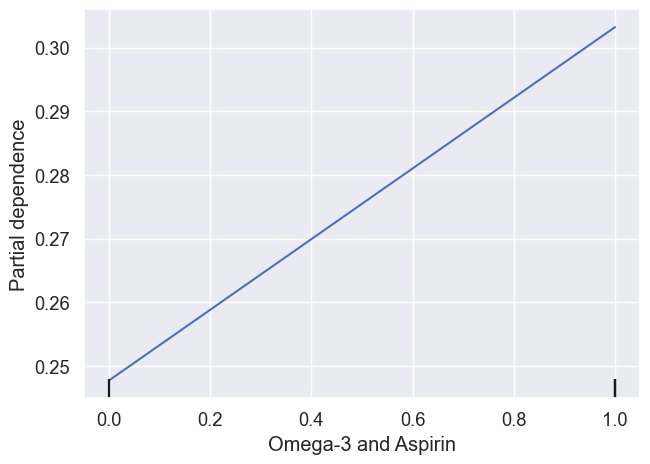

In [54]:
np.random.seed(42)
SEED = check_random_state(42)

from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
import joblib

for algorithm, (clf, parameters) in algorithms.items():
    best_model = TuningGridSearch(clf, X, y, parameters)
    print('Melhor RF = ', best_model)


best_model.fit(X,y)

features = [0]
PartialDependenceDisplay.from_estimator(best_model, X, features)

# Salvando melhor modelo
joblib.dump(best_model, "random_forest.joblib")


In [ ]:
import scipy.stats as stats
import numpy as np

grupo1 = new_df[new_df.classe == 1].hba1c

# Calcula o intervalo de confiança para uma amostra
conf_interval = stats.t.interval(0.95, len(grupo1), loc=np.mean(grupo1), scale=stats.sem(grupo1))

print("Intervalo de confiança para o primeiro grupo:", conf_interval)
